# seiyrdc_buncombe

In [1]:
import numpy as np
import gillespy2
from gillespy2 import Model, Species, Reaction, Parameter, RateRule, AssignmentRule, FunctionDefinition
from gillespy2 import EventAssignment, EventTrigger, Event


from sciope.utilities.priors.uniform_prior import UniformPrior
from sciope.inference.rep_smc_abc import ReplenishmentSMCABC
from sciope.utilities.summarystats.identity import Identity

import matplotlib.pyplot as plt

# To run a simulation using the SSA Solver simply omit the solver argument from model.run().
from gillespy2 import VariableSSACSolver
# from gillespy2 import TauLeapingSolver
# from gillespy2 import TauHybridSolver
# from gillespy2 import ODESolver

In [2]:
class seiyrdc_buncombe(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="seiyrdc_buncombe")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="beta", expression=1))
        self.add_parameter(Parameter(name="kappa", expression=0.3))
        self.add_parameter(Parameter(name="delta", expression=0.005))
        self.add_parameter(Parameter(name="nu", expression=0.2))

        # Species
        self.add_species(Species(name="S", initial_value=258340, mode="discrete"))
        self.add_species(Species(name="E", initial_value=400, mode="discrete"))
        self.add_species(Species(name="I", initial_value=150, mode="discrete"))
        self.add_species(Species(name="Y", initial_value=100, mode="discrete"))
        self.add_species(Species(name="R", initial_value=252, mode="discrete"))
        self.add_species(Species(name="D", initial_value=30, mode="discrete"))
        self.add_species(Species(name="C", initial_value=0, mode="discrete"))

        # Reactions
        self.add_reaction(Reaction(name="exposure", reactants={'S': 1, 'I': 1}, products={'E': 1, 'I': 1}, propensity_function="beta * S * I / 250000"))
        self.add_reaction(Reaction(name="incubation_asymptomatic", reactants={'E': 1}, products={'I': 1}, propensity_function="(1 - nu) * 0.16 * E"))
        self.add_reaction(Reaction(name="incubation_symptomatic", reactants={'E': 1}, products={'Y': 1}, propensity_function="nu * 0.16 * E"))
        self.add_reaction(Reaction(name="recovery", reactants={'Y': 1}, products={'R': 1}, rate=self.listOfParameters["kappa"]))
        self.add_reaction(Reaction(name="death", reactants={'Y': 1}, products={'D': 1}, rate=self.listOfParameters["delta"]))
        self.add_reaction(Reaction(name="clearance", reactants={'I': 1}, products={'C': 1}, rate=self.listOfParameters["kappa"]))

        # Timespan
        self.timespan(np.linspace(0, 38, 39))
model = seiyrdc_buncombe()
compiled_solver = VariableSSACSolver(model)

## Data

In [3]:
import pandas as pd

county_name = "Buncombe"
state_name = "North Carolina"

confirmed_data = pd.read_csv("../data/time_series_covid19_confirmed_US.csv")
dead_data = pd.read_csv("../data/time_series_covid19_deaths_US.csv")
d_confirmed = confirmed_data[(confirmed_data["Admin2"] == county_name) & (confirmed_data["Province_State"] == state_name)]
d_dead = dead_data[(dead_data["Admin2"] == county_name) & (dead_data["Province_State"] == state_name)]

idx_first_confirmed = np.where(d_confirmed.iloc[:,11:].values >= 1)[1][0] - 1
d_confirmed_ts = d_confirmed.iloc[:,11 + idx_first_confirmed:].values
d_dead_ts = d_dead.iloc[:,12 + idx_first_confirmed:].values
d_dead_ts[0,112:] += 10
d_dead_ts = d_dead_ts[:,80:]
d_confirmed_ts = d_confirmed_ts[:,80:]

# obs_data should contain the observed dataset
obs_data = np.vstack([d_confirmed_ts - d_dead_ts, d_dead_ts]).reshape(1,2,-1)

## Prior Distributions

In [4]:
parameter_names = ['beta', 'kappa', 'delta', 'nu']
lower_bounds =    [0     ,       0,       0,    0]
upper_bounds =    [3     ,       1,     0.1,    1]
prior = UniformPrior(np.array(lower_bounds), np.array(upper_bounds))

## Simulator

In [5]:
# Here we use the GillesPy2 Solver
def simulator(params, model):    
    res = model.run(
            solver = compiled_solver,
            show_labels = True,
            seed = np.random.randint(1e8),
            variables = {parameter_names[i] : params[i] for i in range(len(parameter_names))})
    
    # Extract only observed species
    symptomatic = res['Y']
    recovered = res['R']
    dead = res['D']

    return np.vstack([symptomatic + recovered, dead])[np.newaxis,:,:]

# Wrapper, simulator function to abc should should only take one argument (the parameter point)
def simulator2(x):
    return simulator(x, model=model)

## ABC Inference

In [6]:
normalization_values = np.max(obs_data, axis = 2)[0,:]
def max_normalization(data):
    dc = data.copy().astype(np.float32)
    dc[0,0,:] = dc[0,0,:]/normalization_values[0]
    dc[0,1,:] = dc[0,1,:]/normalization_values[1]
    return dc

summary_stat = Identity(max_normalization)

In [7]:
# Start abc instance
abc = ReplenishmentSMCABC(obs_data, # Observed Dataset
                          lambda x : (simulator2(x), 1), # Simulator method
                          prior,
                          summaries_function=summary_stat.compute) # prior

In [8]:
import dask 
with dask.config.set(scheduler = 'processes', workers = 20):
    smc_abc_results = abc.infer(num_samples = 1000)

Tol : 21.129379272460938, R : 10, N_acc : 3800, p_acc : 1.1362, iter_ssa_count : 4796, iter_N_count : 4796
Tol : 5.913640975952148, R : 11, N_acc : 3645, p_acc : 1.038, iter_ssa_count : 4940, iter_N_count : 4940
Tol : 2.737978219985962, R : 11, N_acc : 3470, p_acc : 0.9983272727272727, iter_ssa_count : 5048, iter_N_count : 5048
Tol : 1.644308090209961, R : 13, N_acc : 3430, p_acc : 0.9013538461538461, iter_ssa_count : 5466, iter_N_count : 5466
Tol : 1.2651526927947998, R : 12, N_acc : 3304, p_acc : 0.9118666666666666, iter_ssa_count : 6170, iter_N_count : 6170
Tol : 1.0315581560134888, R : 17, N_acc : 3213, p_acc : 0.7162588235294118, iter_ssa_count : 7925, iter_N_count : 7925
Tol : 0.8923887610435486, R : 20, N_acc : 3049, p_acc : 0.6106, iter_ssa_count : 9621, iter_N_count : 9621
Tol : 0.789914608001709, R : 20, N_acc : 3016, p_acc : 0.6136000000000001, iter_ssa_count : 10639, iter_N_count : 10639
Tol : 0.6790726780891418, R : 26, N_acc : 2846, p_acc : 0.48255384615384617, iter_ssa_c

In [9]:
posterior = smc_abc_results['accepted_samples']

## Analysis

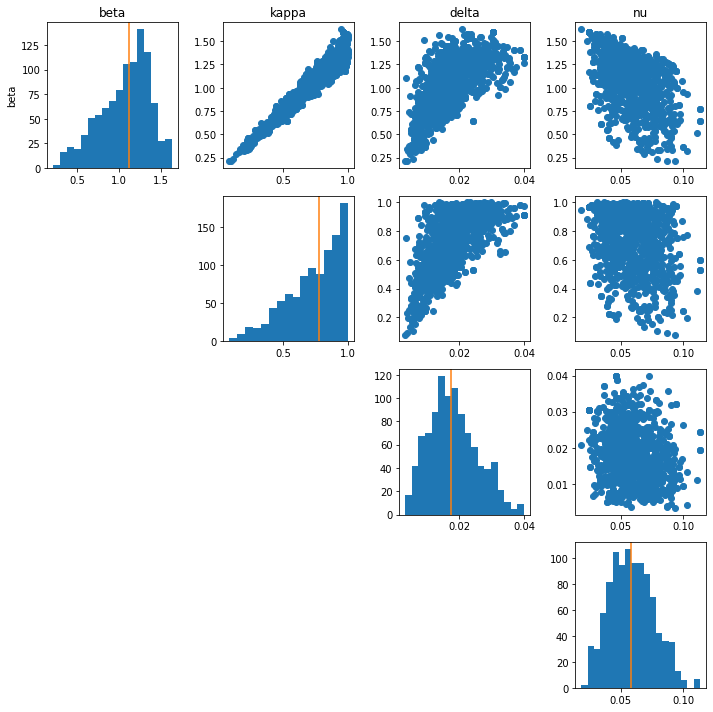

In [10]:
fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1])
for i in range(posterior.shape[1]):
    for j in range(posterior.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(posterior[:,i], bins = 'auto')
                ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
            else:
                ax[i,j].scatter(posterior[:,j], posterior[:,i])
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(10,10)
fig.tight_layout()

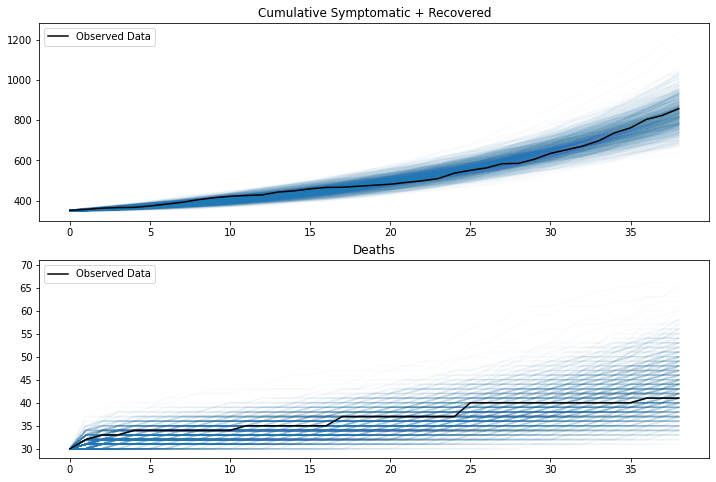

In [11]:
fig, ax = plt.subplots(2)
for i in range(posterior.shape[0]):
    res = simulator2(posterior[i,:])
    ax[0].plot(res[0,0,:], color = 'C0', alpha = 0.02)
    ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.02)
ax[0].plot(obs_data[0,0,:], color = 'black', label = 'Observed Data')
ax[1].plot(obs_data[0,1,:], color = 'black', label = 'Observed Data')
ax[0].set_title("Cumulative Symptomatic + Recovered")
ax[1].set_title("Deaths")
ax[0].legend()
ax[1].legend()
fig.set_size_inches(12, 8)